In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [13]:
pip install SimpleITK

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import os
import cv2
import glob
import json
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm

In [19]:
from params import CLASSES_SEG

from data.dataset import Seg3dDataset

from training.losses import SegLoss
from model_zoo.models_seg import define_model

from util.logger import Config
from util.torch import load_model_weights

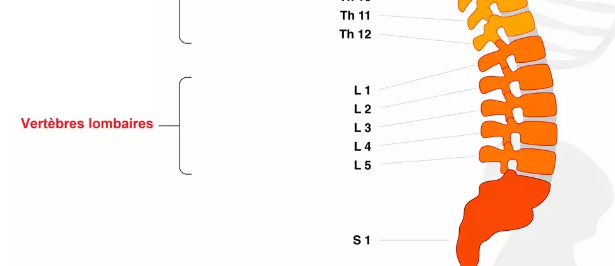

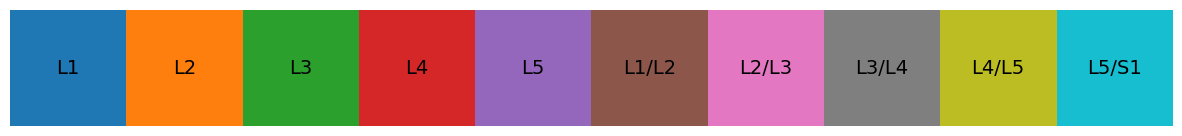

In [20]:
legend = np.arange(1, len(CLASSES_SEG) + 1)
plt.figure(figsize=(15, 5))
plt.imshow(legend[None],  cmap='tab10')
for i in range(len(CLASSES_SEG)):
    plt.text(i, 0, CLASSES_SEG[i], horizontalalignment='center', verticalalignment='center', fontsize=14)
plt.axis(False)
plt.show()

### Spider
- https://spider.grand-challenge.org/data/

In [21]:
DATA_PATH = "../input/spider/"

imgs = sorted(glob.glob(DATA_PATH + 'images/*.mha'))
masks = sorted(glob.glob(DATA_PATH + 'masks/*.mha'))
print('Number of training segmentations :', len(imgs))

SAVE = False
PLOT = True

mapping = {
    1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 
    6: 0, 7: 0, 8: 0, 9: 0,
    201: 10, 202: 9, 203: 8, 204: 7, 205: 6, 206: 0, 207: 0, 208: 0, 209: 0, 100: 0,
}

Number of training segmentations : 447


In [22]:
# for i, (img_path, mask_path) in tqdm(enumerate(zip(imgs, masks)), total=len(imgs)):
#     img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))
#     mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))

#     # mask = np.where(np.isin(mask, np.array(mapping.keys())), mask, 0)
#     # print(np.unique(mask))
#     mask_c = mask.copy()
#     for k in mapping:
#         mask_c[mask == k] = mapping[k]
#     mask = mask_c

#     if img.shape[0] < img.shape[-1]:
#         order = [1, 2, 0]
#         img = img.transpose(order)[::-1]
#         mask = mask.transpose(order)[::-1]

#     assert img.shape == mask.shape

#     mask = mask.transpose(2, 0, 1)
#     img = img.transpose(2, 0, 1)

#     if SAVE:
#         name = img_path.split('/')[-1][:-4]
#         np.save(f"../input/seg_npy/imgs/spider_{name}.npy", img)
#         np.save(f"../input/seg_npy/masks/spider_{name}.npy", mask)

#     if PLOT:
#         # img = (img - img.min()) / (img.max() - img.min())
#         mask_plot = np.where(mask > 0, mask, np.nan)


#         plt.figure(figsize=(20, 10))
#         plt.subplot(1, 2, 1)
#         plt.imshow(img[img.shape[0] // 2], cmap='gray')
#         plt.axis('off')
#         plt.subplot(1, 2, 2)
#         plt.imshow(mask_plot[img.shape[0] // 2], cmap='tab10', interpolation="none")
#         plt.axis('off')
#         plt.show()

#         if i > 0:
#             break

### Spine seg dataset
- https://osf.io/qx5rt/

In [23]:
DATA_PATH = "../input/spine_seg/"

PLOT = True
SAVE = False

  0%|          | 0/34 [00:00<?, ?it/s]

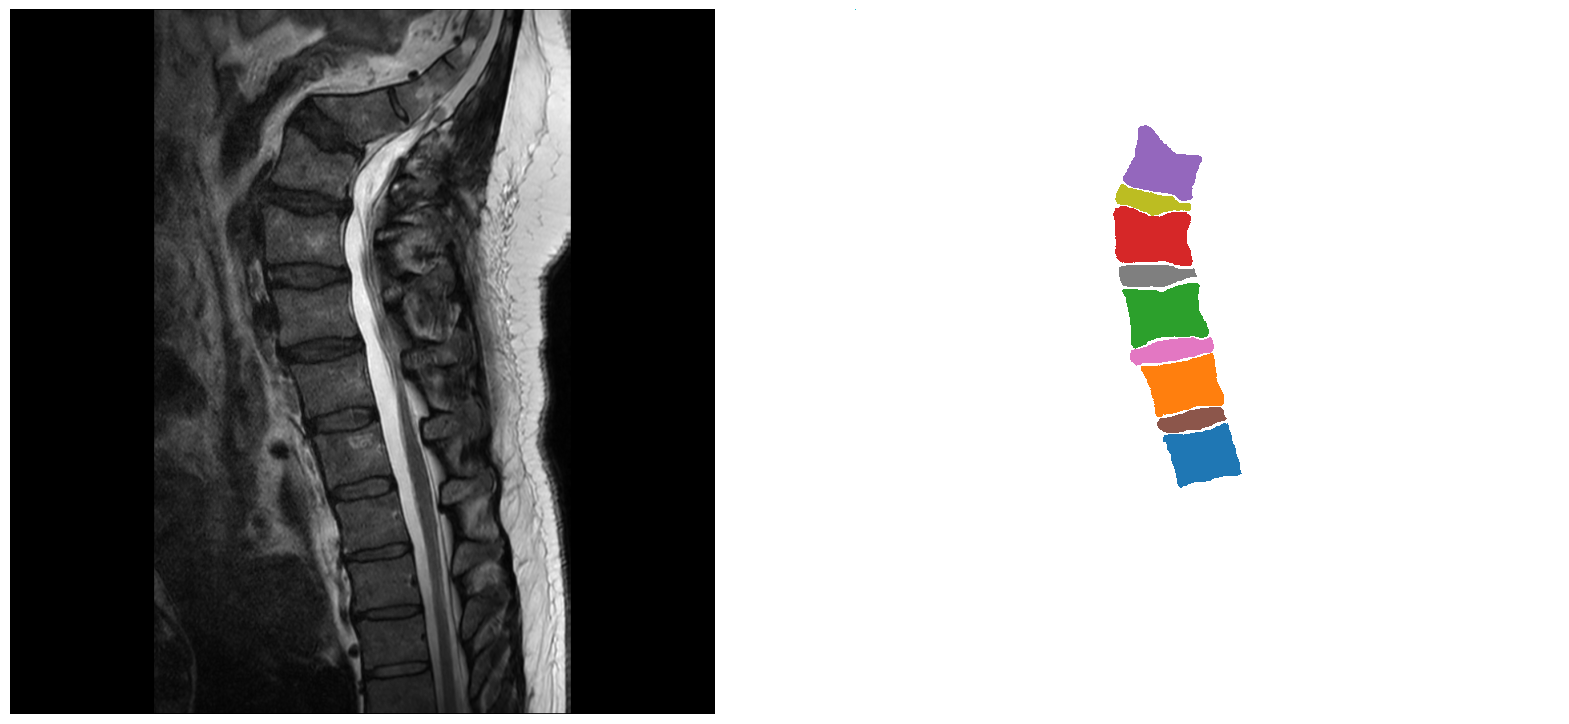

In [24]:
for patient in tqdm(sorted(os.listdir(DATA_PATH))):
    for device in os.listdir(DATA_PATH + patient):
        folder = os.path.join(DATA_PATH, patient, device)

        imgs = sorted(glob.glob(folder + "/Images/*"))

        mask = None
        for i, v in enumerate(["L1", "L2", "L3", "L4", "L5", "BS_L1_2", "BS_L2_3", "BS_L3_4", "BS_L4_5"]):
            mask_path = folder + f"/Labels/{v}.nii.gz"
            if not os.path.exists(mask_path):
                continue
            if mask is None:
                mask = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))
                mask = np.round(mask, 0)
            else:
                mask = np.where(mask > 0, mask, mask + (i + 1) * np.round(sitk.GetArrayFromImage(sitk.ReadImage(mask_path)), 0))

        for img_path in imgs:

            if not any([s in img_path.lower() for s in ["t1_contrast", "t2", "stir"]]):
                continue

            img = sitk.GetArrayFromImage(sitk.ReadImage(img_path))

            try:
                assert img.shape == mask.shape
            except:
                print(f'Skipping {img_path}, wrong shape')
                continue

            
            if SAVE:
                name = img_path.split('/')[-1][:-7]
                np.save(f"../input/seg_npy/imgs/spine_{patient}_{device}_{name}.npy", img)
                np.save(f"../input/seg_npy/masks/spine_{patient}_{device}_{name}.npy", mask)
            

            if PLOT:
                img = (img - img.min()) / (img.max() - img.min())
                mask_plot = np.where(mask > 0, mask, np.nan)
                mask_plot[:, 0, 0] = 10

                plt.figure(figsize=(20, 10))
                plt.subplot(1, 2, 1)
                plt.imshow(img[img.shape[0] // 2], cmap='gray')
                plt.axis('off')
                plt.subplot(1, 2, 2)
                plt.imshow(mask_plot[img.shape[0] // 2], cmap='tab10', interpolation="none")
                plt.axis('off')
                plt.show()

                break

    if PLOT:
        break

In [25]:
if SAVE:
    df = pd.DataFrame(
        {
            "img_path": sorted(glob.glob('../input/seg_npy/imgs/*.npy')),
            "mask_path": sorted(glob.glob('../input/seg_npy/masks/*.npy')),
        }
    )
    df['source'] = df['img_path'].apply(lambda x: "spider" if "spider" in x else "spine_seg")

    df.to_csv('../input/df_seg.csv', index=False)

### Dataset

In [26]:
df = pd.read_csv('../input/df_seg.csv')

In [27]:
pl_folder = "../logs/2024-07-31/6/"
# pl_folder = "../logs/2024-07-31/15/"

df = pd.DataFrame({
    "img_path": sorted(glob.glob(pl_folder + "imgs/*")),
    "mask_path": sorted(glob.glob(pl_folder + "masks/*"))
})
    # df_pl["fold"] = -1


In [28]:
dataset = Seg3dDataset(df, train=True, img_size=(64, 128, 128), load_in_ram=False)

In [29]:
img.max(), img.min()

(1.0, 0.0)

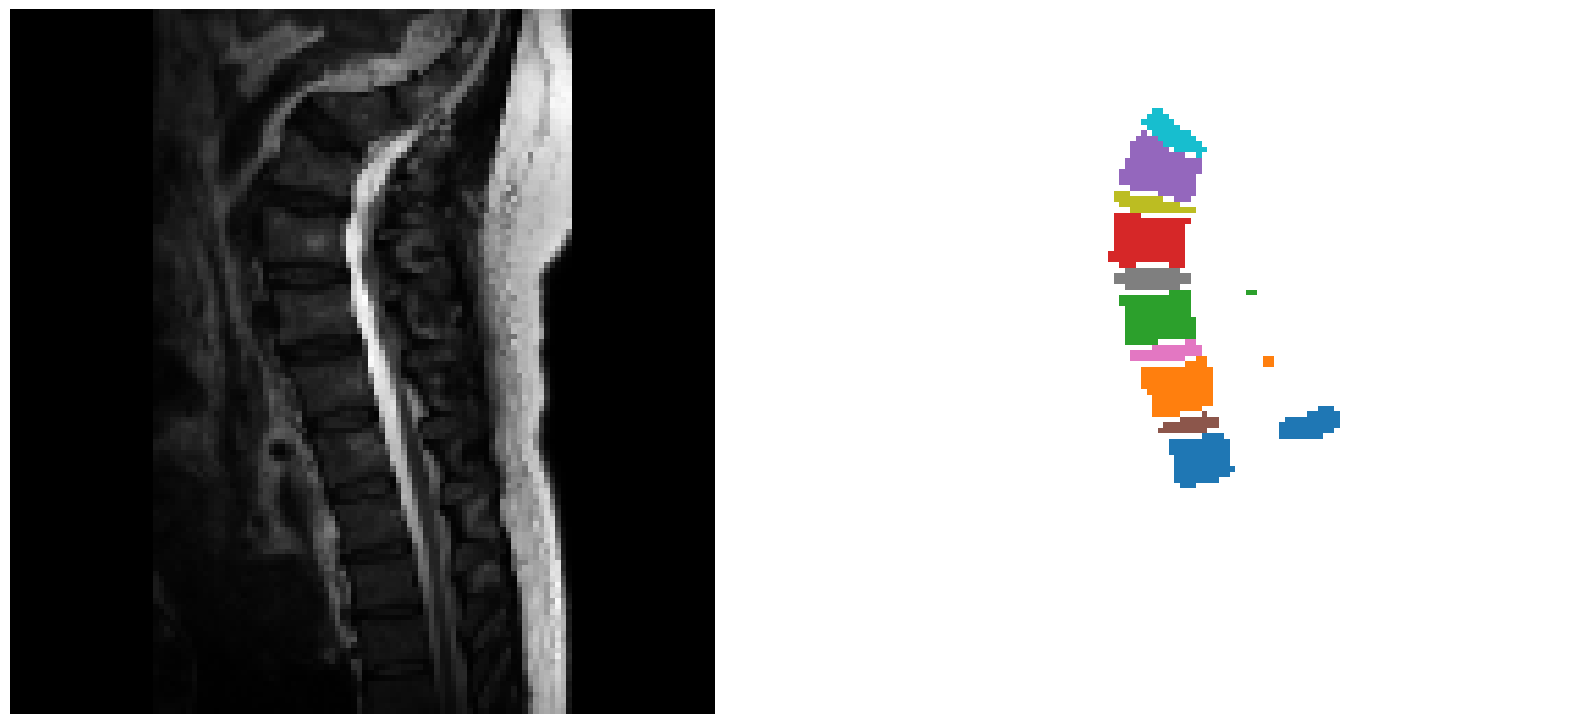

In [30]:
img, mask, w = dataset[0]
img, mask, w = img[0], mask[0], w
f = img.shape[0] // 2

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img[f], cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(np.where(mask[f] > 0, mask[f], np.nan), cmap='tab10', interpolation="none")
plt.axis('off')
# plt.subplot(1, 3, 3)
# # plt.imshow(w[f], cmap='tab10', interpolation="none")
# plt.axis('off')
plt.show()

### Model

In [31]:
model = define_model(
    "Unet",
    # "resnet18d",
    "resnet34d",
    num_CLASSES_SEG=11,
    # num_CLASSES_SEG_aux=config.num_CLASSES_SEG_aux,
    increase_stride=True,
    # use_cls=config.use_cls,
    n_channels=1,
    use_3d=True,
    verbose=1,
)

TypeError: define_model() got an unexpected keyword argument 'num_CLASSES_SEG'

In [ ]:
x, y, w = dataset[0]
x, y, = x.unsqueeze(0), y.unsqueeze(0)

In [ ]:
%%time
pred, _ = model(x)

In [ ]:
cfg = {
        "name": "ce",
        "smoothing": 0,
        "activation": "softmax",
        "aux_loss_weight": 0.0,
        "name_aux": "bce",
        "smoothing_aux": 0,
        "activation_aux": "sigmoid",
        "num_CLASSES_SEG": 11,
    }

loss_fct = SegLoss(cfg)

In [ ]:
loss_fct(pred, torch.zeros(1), y, torch.zeros(1))

### Inference spline_seg

In [37]:
DEVICE = "cuda:0"
# DEVICE = "cpu"

In [38]:
# EXP_FOLDER = "../logs/2024-07-31/6/"
# EXP_FOLDER = "../logs/2024-07-31/15/"
EXP_FOLDER = "../logs/2024-07-31/20/"  
# EXP_FOLDER = "../logs/2024-07-31/21/"
# EXP_FOLDER = "../logs/2024-07-31/22/"
EXP_FOLDER = "../logs/2024-07-31/25/"  # <--- BEST

In [39]:
EXP_FOLDERS = [
    # "../logs/2024-07-31/20/",
    # "../logs/2024-07-31/22/",
    "../logs/2024-07-31/25/"
]

In [59]:
models = []
for exp_folder in EXP_FOLDERS:

    config = Config(json.load(open(exp_folder + "config.json", "r")))

    model = define_model(
        config.decoder_name,
        config.name,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        increase_stride=config.increase_stride,
        use_cls=config.use_cls,
        n_channels=config.n_channels,
        use_3d=config.use_3d,
        verbose=(config.local_rank == 0),
    ).to(DEVICE)

    fold = 0
    model = load_model_weights(model, exp_folder + f"{config.name}_{fold}.pt")
    # model = model.eval()  # HURTS PERFS ?

    models.append(model)


 -> Loading encoder weights from ../logs/2024-07-31/25/resnet34d_0.pt



In [60]:
DATA_PATH = "../input/"

df = pd.read_csv(DATA_PATH + "df_seg.csv")
df = df[df['source'] != "spider"].reset_index(drop=True)

In [61]:
dataset = Seg3dDataset(df, train=False, img_size=config.img_size)
config.img_size

[128, 256, 256]

In [62]:
def get_iou(pred, mask):
    ious = []
    for i in range(1, 10):
        ious.append((((pred == i) * (mask == i)).sum() / (pred == i).sum()).item())
    iou_dict = dict(zip(CLASSES_SEG, ious))
    iou = np.mean(ious)
    return iou_dict, iou

In [63]:
PLOT = False
SAVE = False
USE_FP16 = True

if SAVE:
    os.makedirs(EXP_FOLDER + "masks/", exist_ok=True)
    os.makedirs(EXP_FOLDER + "imgs/", exist_ok=True)

In [64]:
ious = []
for idx in tqdm(range(0, len(df))):

    x, y, w = dataset[idx]

    with torch.inference_mode():
        with torch.cuda.amp.autocast(enabled=USE_FP16):
            preds = []
            for model in models:
                pred, _ = model(x.to(DEVICE).unsqueeze(0))
                preds.append(pred.softmax(1))
            pred = torch.cat(preds, 0).mean(0)
            pred = pred.argmax(0)
            pred = pred.cpu()

    img = x[0]
    mask = y[0]

    iou_dict, iou = get_iou(pred, mask)
    ious.append(iou_dict)

    if SAVE:
        if np.min(list(iou_dict.values())[5:]) > 0.25:
            np.save(
                EXP_FOLDER + "masks/" + dataset.img_paths[idx].split("/")[-1],
                pred.numpy().astype(np.uint8)[::4].copy(),
            )
            np.save(
                EXP_FOLDER + "imgs/" + dataset.img_paths[idx].split("/")[-1],
                x[0].numpy().astype(np.float32)[::4].copy(),
            )

    # if iou < 0.:
    if PLOT:
        if mask.max() < 10:
            mask[:, 0, 0] = 10
        f = img.shape[0] // 2

        if np.min(list(iou_dict.values())[5:]) < 2:
            print("Ious: ", iou_dict)
            plt.figure(figsize=(20, 10))
            plt.subplot(1, 4, 1)
            plt.imshow(img[f], cmap="gray")
            plt.imshow(
                np.where(pred[f] > 0, pred[f], np.nan),
                cmap="tab10",
                interpolation="none",
                alpha=0.2,
            )
            plt.axis(False)
            plt.title("Img + Pred")
            plt.subplot(1, 4, 2)
            plt.imshow(
                np.where(mask[f] > 0, mask[f], np.nan),
                cmap="tab10",
                interpolation="none",
            )
            plt.axis(False)
            plt.title("Truth")
            plt.subplot(1, 4, 3)
            plt.imshow(
                np.where(pred[f] > 0, pred[f], np.nan),
                cmap="tab10",
                interpolation="none",
            )
            plt.axis(False)
            plt.title("Pred")
            plt.subplot(1, 4, 4)
            equal = np.where(mask[f] * (mask[f] == pred[f]), mask[f], np.nan)
            equal[0, 0] = 10
            equal[0, 1] = 1
            plt.axis(False)
            plt.title("Pred == Truth")
            plt.imshow(equal, cmap="tab10", interpolation="none")
            plt.show()

        break

  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
df_iou = pd.DataFrame(ious)  # "../logs/2024-07-31/25/"
pd.concat([
    pd.DataFrame(df_iou.mean()).rename(columns={0: "Mean IoU"}).T,
    pd.DataFrame((df_iou > 0.25).mean()).rename(columns={0: "Mean IoU>0.25"}).T,
    pd.DataFrame((df_iou > 0.5).mean()).rename(columns={0: "Mean IoU>0.50"}).T,
])

,L1,L2,L3,L4,L5,L1/L2,L2/L3,L3/L4,L4/L5
Mean IoU,0.615917,0.645988,0.687394,0.711458,0.701638,0.811795,0.822518,0.846682,0.813036
Mean IoU>0.25,0.905882,0.929412,0.976471,0.988235,0.988235,0.941176,0.929412,0.964706,0.964706
Mean IoU>0.50,0.800000,0.894118,0.952941,0.976471,0.952941,0.894118,0.905882,0.952941,0.917647


Done ! 